In [1]:
import ngmix
import fitsio
import proplot as pplt
import numpy as np
import piff
import galsim
import yaml

In [2]:
%matplotlib inline

In [3]:
TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]

with open(
    "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
    "%s_%s_pizza_cutter_info.yaml" % (TNAMES[1], BANDS[1])
) as fp:
    yml = yaml.safe_load(fp.read())

In [4]:
from des_y6utils.piff import (
    measure_star_t_for_piff_model,
    map_star_t_to_grid,
    measure_t_grid_for_piff_model,
    make_good_regions_for_piff_model_gal_grid,
    make_good_regions_for_piff_model_star_and_gal_grid,
    nanmad,
)

In [ ]:
# find a bad model
for sind, src in enumerate(yml["src_info"]):
    print(sind)
    piff_mod = piff.read(src["piff_path"])
    res = make_good_regions_for_piff_model(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False)
    
    b = res["bbox"]
    flags = res["flags"]
    if flags == 0:
        bf = np.mean(res["bad"])
    else:
        bf = 1.0
    if bf > 1/512:
        break

In [11]:
sind = 40

src = yml["src_info"][sind]
piff_mod = piff.read(src["piff_path"])

img = (
    fitsio.read(src["image_path"], ext=src["image_ext"])
    - fitsio.read(src["bkg_path"], ext=src["bkg_ext"])
)
wgt = fitsio.read(src["weight_path"], ext=src["weight_ext"])

In [12]:
thresh = 5
t_arr = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 0.61})
data = measure_star_t_for_piff_model(piff_mod, img, wgt, piff_prop="GI_COLOR")
ts_arr = map_star_t_to_grid(data)

res_g = make_good_regions_for_piff_model_gal_grid(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False)
res_sg = make_good_regions_for_piff_model_star_and_gal_grid(
    piff_mod, img, wgt, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False,
    flag_bad_thresh=2, any_bad_thresh=5,
)

Text(0.5, 0, 'gal T - star T')

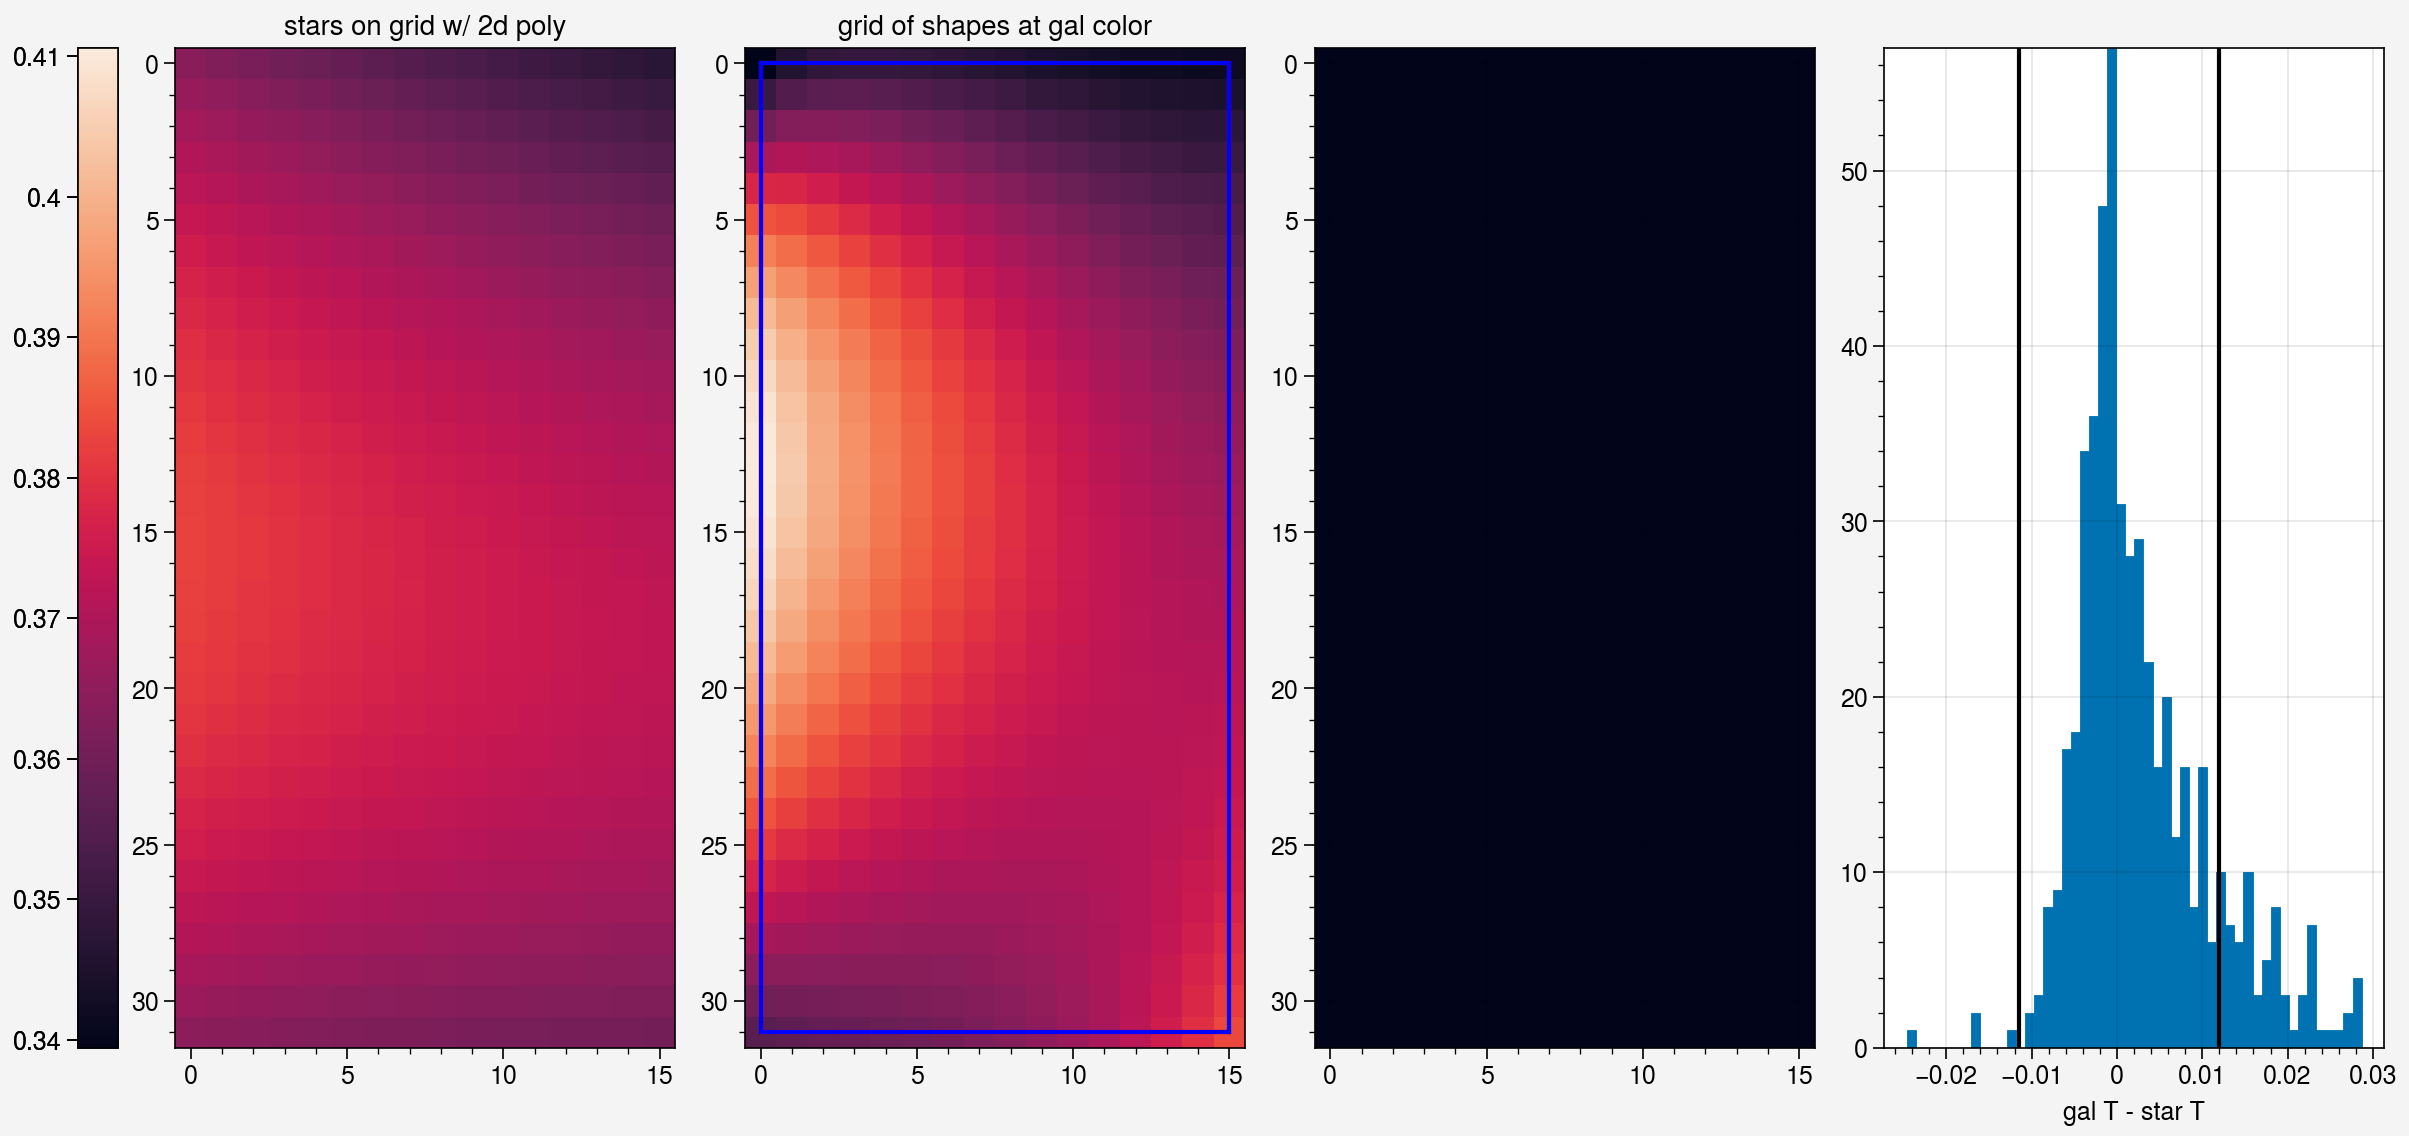

In [13]:
vmin = min(np.nanmin(ts_arr), np.nanmin(t_arr))
vmax = max(np.nanmax(ts_arr), np.nanmax(t_arr))

fig, axs = pplt.subplots(ncols=4, share=0)
h0 = axs[0].imshow(ts_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0].grid(False)
axs[0].set_title("stars on grid w/ 2d poly")
axs[0].colorbar(h0, loc='l')

axs[1].imshow(t_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1].grid(False)
axs[1].set_title("grid of shapes at gal color")

b = res_g["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="red")

b = res_sg["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="blue")

axs[2].imshow(res_sg["bad_msk"], cmap="rocket")

harr = (t_arr-ts_arr).ravel()
std5 = nanmad(harr) * 2
h = axs[3].hist(harr, bins=50)
axs[3].vlines([-std5, np.nanmedian(harr)+std5], 0, np.max(h[0]), color="k")
axs[3].set_xlabel("gal T - star T")

In [13]:
np.mean(res_sg["bad_msk"])

0.134765625

In [ ]:
import ngmix

def get_star_stamp_pos(s, img, wgt):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox = 17
    bbox_2 = (bbox - 1)//2
    
    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        xstart=xint-bbox_2, 
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )

def get_star_piff_obs(piff_mod, s, img, wgt):
    
    sres = get_star_stamp_pos(s, img, wgt)
    
    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    img = piff_mod.draw(
        x=xv, y=yv, chipnum=list(piff_mod.wcs.keys())[0],
        GI_COLOR=s.data.properties["GI_COLOR"],
        image=img, center=cen,
    )
    model_obs = ngmix.Observation(
        image=img.array,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    star_obs = ngmix.Observation(
        image=sres["img"],
        weight=sres["wgt"],
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    return model_obs, star_obs, sres

In [ ]:

x = []
y = []
t = []

for s in piff_mod.stars:

    mobs, sobs, sres = get_star_piff_obs(piff_mod, s, img, wgt)
    
    res = ngmix.admom.AdmomFitter(
        rng=np.random.RandomState(seed=10)
    ).go(mobs, ngmix.moments.fwhm_to_T(1))
    t.append(res["T"])
    x.append(sres["x"])
    y.append(sres["y"])
    

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(np.array([x, y]).T, np.array(t))

In [ ]:
y, x = np.mgrid[0:4096:128, 0:2048:128] + 64
tg = polyreg.predict(np.array([x.ravel(), y.ravel()]).T)

In [ ]:
tg = tg.reshape(x.shape)

In [ ]:
fig, axs = pplt.subplots(ncols=2)
axs[0].imshow(tg)
axs[1].imshow(res["t_arr"])

In [ ]:
def _nanmad(x, axis=None):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis : {int, sequence of int, None}, optional
        `axis` keyword for

    Returns
    -------
    mad: float
        MAD of array x
    """
    return 1.4826*np.nanmedian(np.abs(x - np.nanmedian(x, axis=axis)), axis=axis)


In [ ]:
print(_nanmad(t), _nanmad(tg))

In [ ]:
from des_y6utils.piff import make_good_regions_for_piff_model

In [ ]:
res = make_good_regions_for_piff_model(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=10, verbose=False)

In [ ]:
res["t_std"]

In [ ]:
fig, axs = pplt.subplots()

axs.hist((res["t_arr"] - tg).ravel(), bins=50)

In [ ]:
np.std((res["t_arr"] - tg).ravel()) * 5

In [ ]:
np.max(np.abs(np.max(t) - np.median(t)))

In [ ]:
_nanmad(t)

In [44]:
g = galsim.Gaussian(fwhm=0.5).dilate(1.1)

In [45]:
g

galsim.Transformation(galsim.Gaussian(sigma=0.21233045007200477, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.1, 0.0], [0.0, 1.1]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=0.8264462809917354, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)